### Uncertainty Case Selection Example
This notebook walks the user through some of the process documented in Belobraydic and Kaufman, 2014: <b>Geomodeling Unconventional Plays: Improved Selection of Uncertainty Cases</b><br>
Paper can be found here:<br>
https://www.researchgate.net/publication/269203930_Geomodeling_Unconventional_Plays_Improved_Selection_of_Uncertainty_Cases<br>
or<br>
http://archives.datapages.com/data/urtec/2014/1922075.htm

### Library imports
Dataframes, curve fitting functions, plotting, and input estimated functions

In [1]:
import pandas as pd ##pandas dataframes
import numpy as np ##used for input data estimation
import matplotlib.pyplot as plt ##plotting library
import scipy.stats as stats ##used for trunc-normal distribution for input data estimation
import math
#import scipy.interpolate as interp


### Subroutine area
Grouped curve fitting algorithms and shortest distance

In [2]:
"""Area for subroutines"""

##Functions for curve fitting
def exp_func(t,a,b): ##Exponential function fit
    return a * np.exp(b*t)
def log_func(t,a,b): ##Log function fit
    return a + b*np.log(t)

# Function to find distance 
def shortest_distance(x1, y1, a, b, c):  
    ##Given a point (x1, y1) and a line (ax + by + c = 0).   
    d = abs((a * x1 + b * y1 + c)) / (math.sqrt(a * a + b * b)) 
    return d 

### Inputs and synthetic test data
Basic inputs<br>
Creation of data frame with synthetic x, y, and z values that mimic effective porosity, effective water saturation, and HCPV for an unconventional resource

In [3]:
##Generate dataframe with randomized data
##Inputs
prob_group = [1,5,10,25,33,50,67,75,90,95,99] ##Probability groups of interest (can be reducted)
n = 2000 ##Number of simulated uncertainty cases n should be greater than 300 for statistical purposes (2000 selected for reasonable for Petrel)
tolerance = min(20/n,0.01) ##Value a probabilty case needs to be to prob_group above to be included based on 20/2000 = 1%


x_bar = 0.045; x_sd = 0.05; x_low = 0.0; x_high = 0.1 ##X distribution (set up to mimic effective porosity of an unconventional)
y_bar = 0.8; y_sd = 0.25; y_low = 0.2; y_high = 1.0   ##Y distribution (set up to mimic effective water saturation of an unconventional)

##Using truncated normal distributions to mimic effective porosity and effective water saturation of an unconventional
df = pd.DataFrame(dict(x=stats.truncnorm.rvs(
                              (x_low - x_bar)/x_sd,(x_high-x_bar)/x_sd,loc=x_bar,scale=x_sd,size = n),
                       y=stats.truncnorm.rvs(
                              (y_low - y_bar)/y_sd,(y_high-y_bar)/y_sd,loc=y_bar,scale=y_sd,size = n)),
                  columns = ['x','y'])
 

df['z'] = 100000 * df.x * (1-df.y) ## Z value as estimated HCPV calcuation for given poro and water sat assuming 100000 volume (unitless)
df['z%rank']=df.z.rank(pct=True) ## percent rank calculation based on Z value for entire case population

### Data review
Histogram for x<br>
Histogram for y<br>
Cross plot for x and y

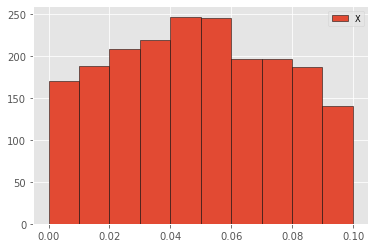

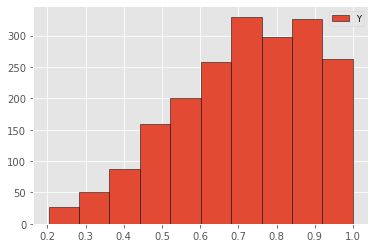

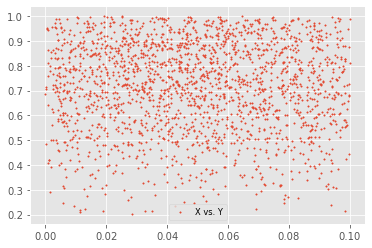

<Figure size 432x288 with 0 Axes>

In [4]:
##X value histogram
plt.style.use('ggplot')
plt.hist(df['x'], label='X',histtype='bar', ec='black')
plt.legend(loc='best', ncol=3, fontsize = 'small')
plt.show()
plt.clf()

##Y value histogram
plt.hist(df['y'], label='Y',histtype='bar', ec='black')
plt.legend(loc='best', ncol=3, fontsize = 'small')
plt.show()
plt.clf()

##Cross plot for X adn Y values
plt.scatter(df['x'],df['y'],s=2, label='X vs. Y')
plt.legend(loc='best', ncol=3, fontsize = 'small')
plt.show()
plt.clf()

#### Note:
Parameters can be adjusted in the inputs to simulate values closer to your unconventional reservoir.

### identification of cases for probability bins
Loop to tag items in the dataframe within tolerance of each probabilty group

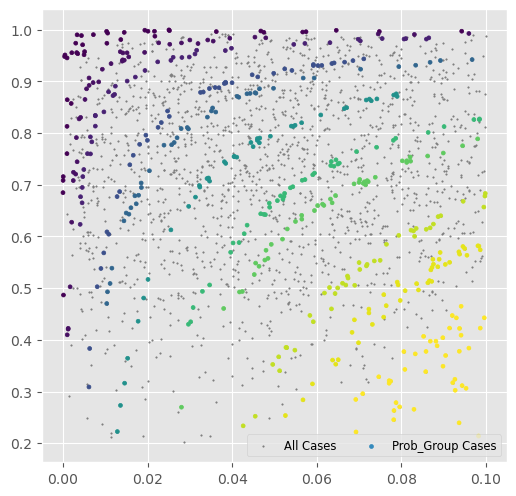

<Figure size 432x288 with 0 Axes>

In [5]:
df['prob_group'] = np.nan ##creating new column of null values in dataframe
for prob in prob_group: ##iterates through all values from prob_group above
    prob_val = prob/100 ##convert prob_group value to decimal
    prob_val_min = prob_val - tolerance ## min prob value (prob - tolerance)
    prob_val_max = prob_val + tolerance ## max prob value (prob + tolerance)
    df.loc[df['z%rank'].between(prob_val_min, prob_val_max), 'prob_group'] = prob ##check if value is within prob_group min-max range
    
##plot of the scatter with the probability tags
plt.figure(figsize=(6,6), dpi=100) ##cross plot size
plt.scatter(df['x'],df['y'], s=1, c = 'tab:gray', label = 'All Cases') ## all cases plotted gray
plt.scatter(df['x'],df['y'], s=8, c = df['prob_group'], label = 'Prob_Group Cases') ## cases selected in for-loop above defining df['prob_group'] by color
plt.legend(loc='best', ncol=3, fontsize = 'small') ##addition of legend for all plotted items
plt.show()
plt.clf()

#### Note:
The p1 and p99 values are used for demonstration and provide little value as a probabilty bin in the provided example

### Analysis section
This section has three main functions:<br>
1) Identify the median and mean values for each prob group and plot the group<br>
2) Calculate the midpoint line using linear regression from the median values calculated in 1 and plot<br>
3) Identify and plot the cases nearest the regression line in 2 and plot thos selected cases

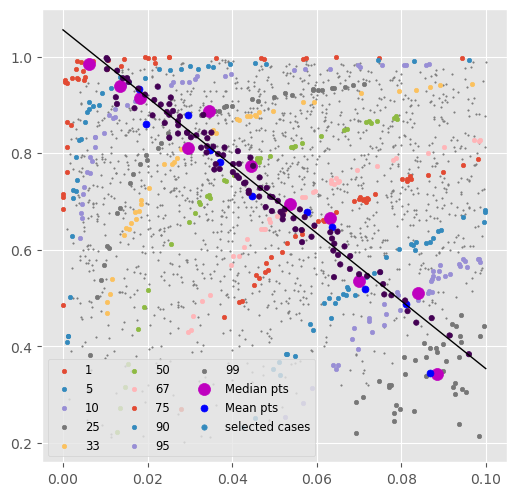

<Figure size 432x288 with 0 Axes>

In [6]:
plt.figure(figsize=(6,6), dpi=100) ##Set up of plot for all cases, prob_groups, fit lines
plt.scatter(df['x'],df['y'], s=1, c = 'tab:gray') ## for all cases
xp_all = np.linspace(df['x'].min() , df['x'].max(), 500) ##calcultion of plot ranges for x axis from all cases

##Midpoint calculations for each prob_group
median_columns = ['prob', 'med_x', 'med_y', 'med_z', 'mean_x', 'mean_y', 'mean_z'] ##column names for dataframe in next line
df_midpoints = pd.DataFrame(columns = median_columns) ##dataframe to hold the calculated midpoints for each probability

"""Each prob bin plotted"""
for prob in prob_group: ##for loop to plot each of the prob_group in the scatter plot above
    temp_df = df.loc[df['prob_group'] == prob].copy() ##temporary dataframe for prob in prob_group results
    x_median, y_median, z_median = temp_df['x'].median(), temp_df['y'].median(), temp_df['z'].median() ##Calc for median of X,Y,Z
    x_mean, y_mean, z_mean = temp_df['x'].mean(), temp_df['y'].mean(), temp_df['z'].mean() ##Calc for mean of X,Y,Z
      
    ##adding median and mean values added to midpoint dataframe
    df_midpoints = df_midpoints.append(pd.Series([prob, x_median, y_median, z_median, 
                                                  x_mean, y_mean, z_mean]
                                                 ,index=median_columns),ignore_index=True)  
    temp_df.sort_values(by=['z'], inplace=True) ##sorting temporary dataframe by z values
    plt.scatter(temp_df['x'],temp_df['y'], s=10, label=str(prob)) ##prob cases added to scatter plot

    
    
"""Midpoint line and selected cases plotted"""
midpoint_line = np.polyfit(x=df_midpoints['med_x'],y=df_midpoints['med_y'],deg=1) ##Linear (deg = 1) numpy polynomial fit for midpoints

df['z rank int'] = (df['z%rank']*100).round(0).astype(int) ##rounding %rank from z value to integer between 0 and 100

df['distance'] = shortest_distance(df['x'], df['y'], -midpoint_line[0], 1, -midpoint_line[1]) ##(x,y,a,b,c) ##shortest distance to midpoint line calculation
    
all_prob_list = df['z rank int'].unique().tolist() ##unique list of z rank int for sorting
all_prob_list.sort() ##sorted list of 'z rank int' for for-loop of selected case identification
df['selected'] = np.nan ##creation of selected tag in data frame with null initial condition
##for-loop to find cases closest to midpoint line
for select_prob in all_prob_list:
    min_value = df.groupby('z rank int')['distance'].min()[df['z rank int']]
    min_value.reset_index(drop = True, inplace = True)
    min_index = df.groupby('z rank int')['distance'].idxmin()[df['z rank int']]
    df.loc[(df['distance'] == min_value) & (df.index == min_index),'selected'] = 1


plt.plot(xp_all,np.polyval(midpoint_line,xp_all), linewidth=1, c='k') ##plotting midpoint line
plt.scatter(df_midpoints['med_x'],df_midpoints['med_y'], s=75, c='m', label='Median pts') ##plotting median points
plt.scatter(df_midpoints['mean_x'],df_midpoints['mean_y'], s=25, c='b', label='Mean pts') ##plotting mean points
plt.scatter(df['x'],df['y'], s=15, c = df['selected'], label = 'selected cases') ##plotting selected cases near midpoint line
plt.legend(loc='best', ncol=3, fontsize = 'small') ##addition of legend for all plotted items
plt.show()
plt.clf()


#### Note:
Mean values would return a similar regression line, but in most cases the mean point are no longer contained within probabilty bins in the cross plot. Median values are more appropriate for this case.

### review of df_midpoints
Note xy values for the median, mean, and estimated locations

In [7]:
df_midpoints

,prob,med_x,med_y,med_z,mean_x,mean_y,mean_z
0,1.0,0.006151,0.984277,8.550663,0.017980,0.932940,12.319217
1,5.0,0.013546,0.939215,71.023713,0.019592,0.860751,71.814978
2,10.0,0.018248,0.914856,145.749281,0.029538,0.878100,143.799442
3,25.0,0.034614,0.886320,409.919651,0.034669,0.806134,408.830549
4,33.0,0.029657,0.810766,551.766368,0.037189,0.782670,551.451432
5,50.0,0.044435,0.773830,992.845996,0.044660,0.712279,994.893321
6,67.0,0.053767,0.694192,1676.041660,0.057598,0.678997,1673.950451
7,75.0,0.063234,0.665183,2079.552996,0.063510,0.647273,2084.213832
8,90.0,0.070005,0.536150,3243.775175,0.071319,0.519810,3261.888702
9,95.0,0.084045,0.510439,4071.175035,0.081134,0.487392,4059.426288


### review of the selected cases 
printing sample of selected cases for review<br>
These cases are storted by 'z rank int' and would be ready to be recreated and sent for dynamic simulation

In [8]:
print(df[df['selected'].notna()].sort_values(by=['z rank int'])) ##review of all cases marked as selected along the midpoint line

             x         y            z  z%rank  prob_group  z rank int  \
582   0.010317  0.996866     3.232936  0.0040         1.0           0   
1678  0.010560  0.993452     6.914208  0.0085         1.0           1   
1512  0.010384  0.973876    27.126829  0.0195         1.0           2   
270   0.012819  0.970785    37.451068  0.0270         NaN           3   
1871  0.014166  0.955139    63.551117  0.0430         5.0           4   
...        ...       ...          ...     ...         ...         ...   
556   0.081470  0.473202  4291.820912  0.9630         NaN          96   
429   0.083534  0.449361  4599.728272  0.9725         NaN          97   
1377  0.087172  0.458680  4718.790535  0.9765         NaN          98   
1398  0.091392  0.422798  5275.145348  0.9865        99.0          99   
682   0.095966  0.384065  5910.870535  0.9960        99.0         100   

      distance  selected  
582   0.001972       1.0  
1678  0.001730       1.0  
1512  0.001207       1.0  
270   0.000768 

### final case selection plotting 
plotting selected cases singlely colored by percent rank

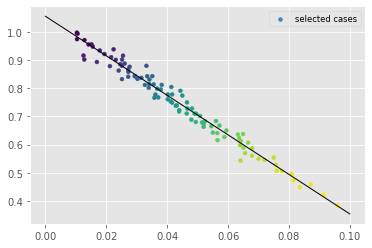

<Figure size 432x288 with 0 Axes>

In [9]:
##plot for the selected cases along midpoint line
##assumption is that these geologically reasonable cases would be sent for dynamic simulation or other analyses
df.loc[df['selected'] == 1, 'selected_z%rank'] = df['z%rank'] ## getting z-rank for the selected cases for display
plt.plot(xp_all,np.polyval(midpoint_line,xp_all), linewidth=1, c='k') ##plotting midpoint line
plt.scatter(df['x'],df['y'], s=15, c = df['selected_z%rank'], label = 'selected cases') ##plotting selected cases colored by z%rank
plt.legend(loc='best', ncol=3, fontsize = 'small') ##addition of legend
plt.show()
plt.clf()